In [261]:
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim 
from PIL import Image

import matplotlib.pyplot as plt

torch.manual_seed(0)

Inspecting the data
First we give you a short overview of the structure of the data, so that you have all the necessary information for building a DataLoader and your first model.

Folder Structure as follows:

* data
    * class1
        * image1
        * image2

    * class2
        * image3
        * image4

    * ...


First we get all folder names in the 'data' folder and save them as our class names.

In [9]:
#datafolder = '..\\data\\frames'
datafolder = 'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\data\\frames'
classes = os.listdir(datafolder)

Next we fit a Label Encoder to transform our class names to integers and then create a dataframe which contains all image paths and thei respective class.

In [25]:
label_encoder = LabelEncoder().fit(classes)

data_df = pd.DataFrame(columns=['image_path', 'label'])

for class_ in classes:
    for image in os.listdir(datafolder + '\\' + class_):
        row = {'image_path': datafolder + '\\' + class_+ '\\' + image, 'label':label_encoder.transform([class_])[0]}
        data_df = data_df.append(row, ignore_index=True)

data_df.head()

,image_path,label
0,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0
1,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0
2,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0
3,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0
4,C:\Users\cwimmer\OneDrive - Capgemini\Projekte...,0


In [30]:
data_df.iloc[0][0]

'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\data\\frames\\kermit\\Muppets-02-01-01_f1000.jpg'

Now we shuffle our dataset and then split it in a train, validation and test dataset.

In [31]:
data_df = shuffle(data_df, random_state=1)
train_val_df, test_df = train_test_split(data_df, random_state=1, test_size=0.2)
train_df, val_df = train_test_split(train_val_df, random_state=1, test_size=0.2)
print('# Train-Examples>>> {}\n# Val-Examples \t>>> {}\n# Test-Examples >>> {}\n'.format(len(train_df), len(val_df), len(test_df)))

# Train-Examples>>> 1488
# Val-Examples 	>>> 372
# Test-Examples >>> 466



## Creating a PyTorch Dataset

This Dataset Class should inhert the torch.utils.data.Dataset class and overwrite the __init__, __len__ and __getitem__ methods.


In [32]:
class imageDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_loader_df, transform):
        self.name_frame = data_loader_df
        self.transform = transform
    
    def __len__(self):
        '''Return the length of the dataframe as an integer'''
        length = len(self.name_frame)
        return length

    def __getitem__(self, idx):
        '''
        1. Get the path of the image with the index
        2. open the Image with the PIL Library
        3. transform the image with the transformer
        4. get the label of the image witht the index
        5. retrun the sample as a tuple
        '''
        img_name = self.name_frame.iloc[idx].image_path
        image = Image.open(img_name)
        image = image.convert('RGB')
        image = self.transform(image)
        label = self.name_frame.iloc[idx].label
        sample = (image, label)
        return sample

A transformer object is accessible under imageTransformer.

In [33]:
resize_size = 260 # smallest side of image resized to 255px
output_size = 256 # image cropped so it has size 244x244px

imageTransformer = transforms.Compose([
    transforms.Resize((resize_size)),
    transforms.CenterCrop(output_size),
    transforms.ToTensor()
])

## Create the PyTorch Datasets

Now we use our implemented class to create the train, test and validation dataset as PyTorch datasets.

_Side Note: The test set is not used in this Example but it is common to validate and compare different models with the validation set and then test the best model on this unused test set. This is done to avoid overfitting a model only to the validation set which does not generalize to unseen data._

In [56]:
train_dataset = imageDataset(train_df, transform=imageTransformer)
test_dataset = imageDataset(test_df, transform=imageTransformer)
val_dataset = imageDataset(val_df, transform=imageTransformer)

In [35]:
# test our datasets by printing the shape of the first sample image
train_dataset[0][0].shape

torch.Size([3, 256, 256])

The shape of our images is: (channels, height, width) with channels being the red, green and blue channel in RGB.

## Create a PyTorch Dataloader

Next we want to create Dataloader Objects for out datasets which can be used to train our model. This Dataloader object should be used in that way:

for images, labels in dataloader:
    model.train(images, labels)
    

* images as tensor with shape (batch_size, channels, height, width)
* labels as tensor with shape (batch_size)


Therefor we use the torch.utils.data.DataLoader class to transform our datasets in dataloader. But first we have to define the batch size to use.


In [59]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)
# train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

The worker paramter defines how many python subprocesses should be launched to load the data while training. This is especially usefull when training with a gpu.

In [60]:
# test our dataloader by printing the shape of the first batch
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32])


## Designing the Neural Network

In this task we implement the architecture of our convolutional neural network. In order to do so we create a class which inherits nn.Module and overwrite the __init__ and the forward method.

In the __init__ function we define the layers of our networkk and the forward function specifies how the input should pass through our layers - in other words the architecture.



 

**Architecture**

We are goining to implement a simple 2-dimensional Convolutional Neural Network with 2 convolutional layers and 1 hidden fully connected layer and an output layer. We use a very simple network to be able to run our example in rather short time - but in the same manner all well known networks (AlexNet, VGG,...) can be rebuilt.

Similar to the image below:

<img src="https://miro.medium.com/max/1000/1*cPAmSB9nziZPI73VC5HAHg.png">

Our convolutional layers should extract features from the images and the fully connected layers are used to classify the images.

The specifications we use in this tutorial are as follows:
* Conv1: out_channels=15, kernel_size=3, padding=1, stride=1 (image size stays the same with this config)
* Conv2: out_channels=30, kernel_size=3, padding=1, stride=1 (image size stays the same with this config)
* FullyConnected: out_features=100
* output: Calculate 

Pooling: max-pooling with size 2 and stride 2

Activation: Rectified Linear Unit in hidden Layers and Softmax for output layer

Information about the different classes in the torch.nn module can be found here: <a href=https://pytorch.org/docs/stable/nn.html>toch.nn</a>


In [142]:
class Net(nn.Module):
    def __init__(self, image_size, num_classes):
        super(Net, self).__init__()
        self.image_size = image_size
        self.num_classes = num_classes
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.fc = nn.Linear(in_features=int(self.image_size / 2 / 2 * self.image_size / 2 / 2 * 128), out_features=100)
        self.out = nn.Linear(in_features=100, out_features=num_classes)
    def forward(self, x):
        # Convolutional Layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # Convolutional Layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # transform from 2d to 1d
        x = x.view(-1, int(self.image_size / 2 / 2 * self.image_size / 2 / 2 * 128))
        # Fully Connected Layer
        x = self.fc(x)
        x = self.relu(x)
        # Output Layer
        x = self.out(x)
        return x

In [143]:
# set the device we are using for training - if you are lucky to have a gpu nearby
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the Network
model = Net(output_size, len(classes)).to(device)

## Define Hyperparamters

In this task we define 2 very important Hyperparamters for out training.

1. The Optimizer Function (in torch.optim module)
2. The Loss Criterion (in torch.nn module)

We use the Adam Optimizer and the Cross Entropy Loss.


In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

## Train Model

This is step we finally train our model with our trainings data. To do so we have to write a function which contains a for loop that iterates over every batch in our training data!

In [137]:
def train_model(model, train_loader, optimizer, criterion, device=torch.device('cpu')):
    # initialize metrics for training
    train_loss = train_accuracy = counter = 0
    # for-loop 
    for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clear optimizer
            optimizer.zero_grad()
            # Forward pass
            output = model.forward(inputs)
            # Loss
            loss = criterion(output, labels)
            # calculate gradients (backpropogation)
            loss.backward()
            # Adjust parameters based on gradients
            optimizer.step()
            # Add the loss to the training set's running loss
            train_loss += loss.item()*inputs.size(0)
            # Calcuate Train_Accuracy
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)            
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            

            # Print the progress of our training
            counter += 1
            print('{}{}{} Train-Batches Progressed\r'.format(counter, "/", len(train_loader)), end="")

    train_loss = round(train_loss/len(train_loader.dataset), 4)
    train_accuracy = round(train_accuracy/len(train_loader), 4)
    print('Training Loss: {} \t\tTraining Accuracy: {}'.format(train_loss, train_accuracy))
    
    torch.save(model.state_dict(), 'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\src\\Computer Vision\\models\\.pt')
    
    return model

In [138]:
train_model(model, train_loader, optimizer, criterion, device=device)

Training Loss: 0.4124 		Training Accuracy: 0.8324


## Validate Model

This is step we validate our trained model with our validation data. To do so we write a function which implements a for loop that iterates over every batch in our validation data!

Same as before you have to implement the for loop by writing the code suggested in the comments.

In [128]:
def validate_model(model,val_loader,criterion, device=torch.device('cpu')):
        # initialize metrics for every epoch
        val_loss = 0
        val_accuracy = 0 
        counter = 0
        
        y_true = torch.tensor([], dtype=torch.long, device=device)
        all_outputs = torch.tensor([], device=device)
        
        
        # Tell torch not to calculate gradients
        with torch.no_grad():
            for inputs, labels in val_loader:  
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                output = model.forward(inputs)            
                # Calculate Loss
                valloss = criterion(output, labels)            
                # Add loss to the validation set's running loss
                val_loss += valloss.item()*inputs.size(0)
                # Since our model outputs a LogSoftmax, find the real           
                # Get the top class of the output
                top_p, top_class = output.topk(1, dim=1)


                # See how many of the classes were correct?
                equals = top_class == labels.view(*top_class.shape)            
                # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                # Print the progress of our evaluation
                counter += 1

                #outputs = model(*inputs)
                y_true = torch.cat((y_true, labels), 0)
                all_outputs = torch.cat((all_outputs, output), 0)
                
                
                print('{}{}{} Validation-Batches Progressed\r'.format(counter, "/", len(val_loader)), end="")
                             
        
        y_true = y_true.cpu().numpy()  
        _, y_pred = torch.max(all_outputs, 1)
        y_pred = y_pred.cpu().numpy()
        y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
                
        # Get the average loss for the entire epoch
        val_loss = round(val_loss/len(val_loader.dataset), 4)
        val_accuracy = round(val_accuracy/len(val_loader), 4)
        # Print out the information
        print('Validation Loss:  {} \tValidation Accuracy: {}'.format(val_loss, val_accuracy))
        return val_loss, val_accuracy, y_true, y_pred, y_pred_prob

In [124]:
validate_model(model,val_loader,criterion, device=device)

Validation Loss:  0.5139 	Validation Accuracy: 0.7885


## Train and Validate Model

In [ ]:
model = model.to(torch.device('cpu'))
torch.save(model.state_dict(), 'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\src\\Computer Vision\\models\\.pt')

In [187]:
def train_validate_model(model, model_name, train_loader, val_loader, optimizer, criterion, epochs, device=torch.device('cpu')):
    
    case_list = []
    
    for epoch in range(epochs):
        print('Epoch {} ...'.format(epoch+1))
        
        ### Train
            # initialize metrics for training
        train_loss = train_accuracy = counter = 0
        # for-loop 
        for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Clear optimizer
                optimizer.zero_grad()
                # Forward pass
                output = model.forward(inputs)
                # Loss
                loss = criterion(output, labels)
                # calculate gradients (backpropogation)
                loss.backward()
                # Adjust parameters based on gradients
                optimizer.step()
                # Add the loss to the training set's running loss
                train_loss += loss.item()*inputs.size(0)
                # Calcuate Train_Accuracy
                top_p, top_class = output.topk(1, dim=1)
                # See how many of the classes were correct?
                equals = top_class == labels.view(*top_class.shape)            
                # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


                # Print the progress of our training
                counter += 1
                print('{}{}{} Train-Batches Progressed\r'.format(counter, "/", len(train_loader)), end="")

        train_loss = round(train_loss/len(train_loader.dataset), 4)
        train_accuracy = round(train_accuracy/len(train_loader), 4)
        print('Training Loss: {} \t\tTraining Accuracy: {}'.format(train_loss, train_accuracy))
    
        torch.save(model.state_dict(), 'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\src\\Computer Vision\\models\\model-{}.pt'.format(epoch+1))
    
        
        
        ### Validation
        # initialize metrics for every epoch
        val_loss = 0
        val_accuracy = 0 
        counter = 0
        
        y_true = torch.tensor([], dtype=torch.long, device=device)
        all_outputs = torch.tensor([], device=device)
        
        
        # Tell torch not to calculate gradients
        with torch.no_grad():
            for inputs, labels in val_loader:  
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                output = model.forward(inputs)            
                # Calculate Loss
                valloss = criterion(output, labels)            
                # Add loss to the validation set's running loss
                val_loss += valloss.item()*inputs.size(0)
                # Since our model outputs a LogSoftmax, find the real           
                # Get the top class of the output
                top_p, top_class = output.topk(1, dim=1)


                # See how many of the classes were correct?
                equals = top_class == labels.view(*top_class.shape)            
                # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                # Print the progress of our evaluation
                counter += 1
                
                # catinate all true labels
                y_true = torch.cat((y_true, labels), 0)
                # catinate all predicted labes
                all_outputs = torch.cat((all_outputs, output), 0)
                
                
                print('{}{}{} Validation-Batches Progressed\r'.format(counter, "/", len(val_loader)), end="")
        
        ### store the metrics for graphs, confusion matrix, ROC and AUC for later
        # y_true to numpy
        y_true = y_true.cpu().numpy()  
        # y_pred to numpy (all_outputs)
        _, y_pred = torch.max(all_outputs, 1)
        
        # y_pred to numpy (all_outputs)
        y_pred = y_pred.cpu().numpy()
        # get prediction probability of all outputs to numpy
        y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
        
   
        
        # Get the average loss for the entire epoch
        val_loss = round(val_loss/len(val_loader.dataset), 4)
        val_accuracy = round(val_accuracy/len(val_loader), 4)
        # Print out the information
        print('Validation Loss:  {} \tValidation Accuracy: {}'.format(val_loss, val_accuracy))
        
        # save model
        torch.save(model.state_dict(), 'C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\src\\Computer Vision\\models\\{}-epoch-{}-val_acc-{}.pt'.format(model_name,(epoch+1), val_accuracy))

        # save every metric in a dict
        case = {'train_accuracy': train_accuracy, 'train_loss': train_loss,
                                  'val_accuracy': val_accuracy, 'val_loss': val_loss, 'y_true' : y_true,
                                  'y_pred' : y_pred, 'y_pred_prob' :y_pred_prob}
        
        
        # append each metric dict per epoch
        case_list.append(case)
        

        print('-------------')
    return case_list

In [189]:
result = train_validate_model(model, kirmet_detection, train_loader, val_loader, optimizer, criterion, epochs, device=device)

Epoch 1 ...
Training Loss: 0.7711 		Training Accuracy: 0.6297
Validation Loss:  0.5701 	Validation Accuracy: 0.701
-------------
Epoch 2 ...
Training Loss: 0.5542 		Training Accuracy: 0.7327
Validation Loss:  0.444 	Validation Accuracy: 0.8161
-------------
Epoch 3 ...
Training Loss: 0.4147 		Training Accuracy: 0.8371
Validation Loss:  0.3313 	Validation Accuracy: 0.8698
-------------
Epoch 4 ...
Training Loss: 0.2561 		Training Accuracy: 0.9149
Validation Loss:  0.3133 	Validation Accuracy: 0.8552
-------------
Epoch 5 ...
Training Loss: 0.144 		Training Accuracy: 0.9535
Validation Loss:  0.231 	Validation Accuracy: 0.9089
-------------
Epoch 6 ...
Training Loss: 0.0909 		Training Accuracy: 0.9701
Validation Loss:  0.2282 	Validation Accuracy: 0.9073
-------------
Epoch 7 ...
Training Loss: 0.0483 		Training Accuracy: 0.9887
Validation Loss:  0.2502 	Validation Accuracy: 0.9151
-------------
Epoch 8 ...
Training Loss: 0.0299 		Training Accuracy: 0.9953
Validation Loss:  0.2925 	Valida

### Plotting the Training Curve

In [299]:
def get_metrics_df(results_from_model):
    df = pd.DataFrame(results_from_model[1])
    df = df.drop(['y_true', 'y_pred', 'y_pred_prob'], axis=1)
#    df['val_accuracy'] = df['val_accuracy'].div(12)
#    df['val_loss'] = df['val_loss'].div(372)
    df['epoch'] = df.index + 1
    return df

In [300]:
df = get_metrics_df(resut)
df.head()

,train_accuracy,train_loss,val_accuracy,val_loss,epoch
0,0.6297,0.7711,0.701042,0.570064,1
1,0.7327,0.5542,0.816146,0.443957,2
2,0.8371,0.4147,0.869792,0.331258,3
3,0.9149,0.2561,0.855208,0.313300,4
4,0.9535,0.1440,0.908854,0.230981,5


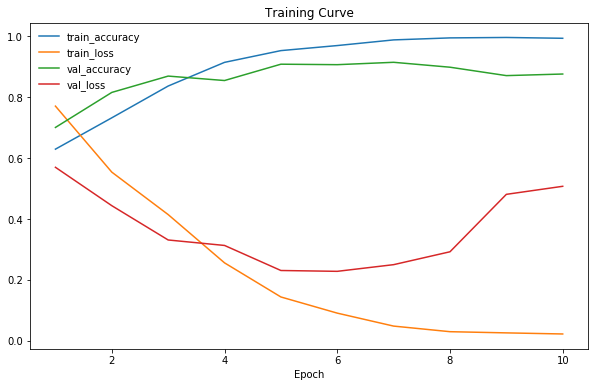

In [304]:
plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

plt.plot(df['epoch'], df['train_accuracy'], label = 'train_accuracy')
plt.plot(df['epoch'], df['train_loss'], label = 'train_loss')
plt.plot(df['epoch'], df['val_accuracy'], label = 'val_accuracy')
plt.plot(df['epoch'], df['val_loss'], label = 'val_loss')


plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

plt.savefig('C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\src\\Computer Vision\\plots\\Trainingcurve.png')

plt.show()

## Load Best model

In [305]:
# Initialize the Network to reset it
model = Net(output_size, len(classes)).to(device)

model.load_state_dict(torch.load('C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\src\\Computer Vision\\models\\model-7.pt'))
model.eval()

Net(
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=524288, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=2, bias=True)
)

## Test Model

In [306]:
def test_model(model,test_loader,criterion, device=torch.device('cpu')):
        # initialize metrics for every epoch
        test_loss = 0
        test_accuracy = 0 
        counter = 0
        
        y_true = torch.tensor([], dtype=torch.long, device=device)
        all_outputs = torch.tensor([], device=device)
        
        
        # Tell torch not to calculate gradients
        with torch.no_grad():
            for inputs, labels in test_loader:  
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass
                output = model.forward(inputs)            
                # Calculate Loss
                testloss = criterion(output, labels)            
                # Add loss to the validation set's running loss
                test_loss += testloss.item()*inputs.size(0)
                # Since our model outputs a LogSoftmax, find the real           
                # Get the top class of the output
                top_p, top_class = output.topk(1, dim=1)


                # See how many of the classes were correct?
                equals = top_class == labels.view(*top_class.shape)            
                # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                # Print the progress of our evaluation
                counter += 1

                #outputs = model(*inputs)
                y_true = torch.cat((y_true, labels), 0)
                all_outputs = torch.cat((all_outputs, output), 0)
                
                
                print('{}{}{} Test-Batches Progressed\r'.format(counter, "/", len(test_loader)), end="")
                             
        
        y_true = y_true.cpu().numpy()  
        _, y_pred = torch.max(all_outputs, 1)
        y_pred = y_pred.cpu().numpy()
        y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
                
        # Get the average loss for the entire epoch
        test_loss = round(test_loss/len(test_loader.dataset), 4)
        test_accuracy = round(test_accuracy/len(test_loader), 4)
        # Print out the information
        print('Test Loss:  {} \tTest Accuracy: {}'.format(test_loss, test_accuracy))
        return test_loss, test_accuracy, y_true, y_pred, y_pred_prob

In [307]:
test_metrics = test_model(model,test_loader,criterion, device=device)

Test Loss:  0.2521 	Test Accuracy: 0.9088


## ROC, Confusion Matrix, Accuracy, Recall, F1-Score with test-set

In [324]:
nb_classes = 2
pred = test_metrics[4]
target = test_metrics[2]

conf_matrix = torch.zeros(nb_classes, nb_classes)
        
for t, p in zip(target, pred):
    conf_matrix[t, p] += 1

print('Confusion matrix\n', conf_matrix)

TP = conf_matrix.diag()[1]
TP

Confusion matrix
 tensor([[114.,  34.],
        [  9., 309.]])


tensor(309.)

In [326]:
TN = conf_matrix[idx.nonzero()[:, None], idx.nonzero()].sum() #conf_matrix[idx[:, None], idx].sum() - conf_matrix[idx, c].sum()
            # all non-class samples classified as class
FP = conf_matrix[idx, c].sum()
            # all class samples not classified as class
FN = conf_matrix[c, idx].sum()

print('TP {}, TN {}, FP {}, FN {}'.format(TP, TN, FP, FN))

C:\w\1\s\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
C:\w\1\s\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


TP 309.0, TN 114.0, FP 34.0, FN 9.0


### ROC Curve

In [358]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_prob = test_metrics[4][:, 1]

fpr, tpr, _ = roc_curve(target, y_pred_prob)
roc_auc = auc(fpr, tpr)

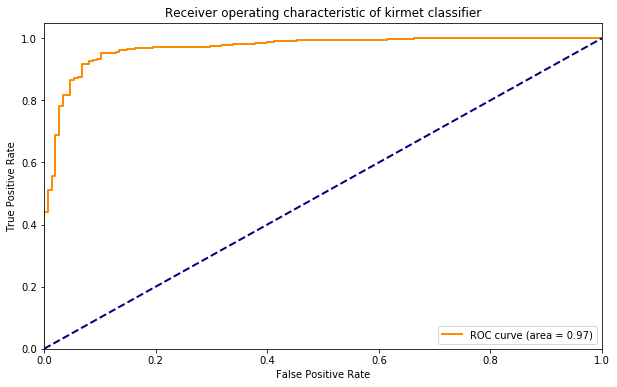

In [360]:
plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of kirmet classifier')
plt.legend(loc="lower right")


plt.savefig('C:\\Users\\cwimmer\\OneDrive - Capgemini\\Projekte\\Similarity Modelling 2\\src\\Computer Vision\\plots\\ROC.png')


plt.show()